In [176]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.special import erf

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.style'] = 'italic'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titley'] = 1.05
plt.rcParams['axes.titlepad'] = -40
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#008080', '#DB803D', '#A6A14D', '#82C9B1', '#F3C887', '#DDD99B'])

# global timestep
DT = 0.005 # ns

#conversion constants
amu_to_ng = 1.66e-15 #1 amu = 1.66e-15 ng
kB = 8.31446261815324 #J/KMol
kB_reduced = 0.0138*1e-9 #pNnm/K

In [50]:
# Super simple energy functions based on distance
def E_ab(r, **kwargs):
    return(-abs(1/r))

def E_ac(r, **kwargs):
    return(-abs(2/r))

def E_bc(r, **kwargs):
    return(0)

def E_LJ(r, **kwargs):
    if 's' in kwargs.keys():
        s = kwargs['s']
    else:
        s = 1
        
    return(4*1 * ((s/r)**12 - (s/r)**6))

In [169]:
# Force functions (derivatives of the energy functions)
# r is the vector from p to q
def F_ab(r, **kwargs):
    mag = (1/np.linalg.norm(r)**2)
    dir = (r)/np.linalg.norm(r)
    return(mag*dir)

def F_ac(r, **kwargs):
    mag = (2/np.linalg.norm(r)**2)
    dir = (r)/np.linalg.norm(r)
    return(mag*dir)

def F_bc(r, **kwargs):
    return np.zeros_like(r)

def F_lj(r, **kwargs):
    if 'mass' in kwargs.keys(): m = kwargs['mass']
    else: m = 1

    if 's' in kwargs.keys(): s = kwargs['s']
    else: s = 1

    if 'e' in kwargs.keys(): e = kwargs['e']
    else: e = 1

    rnorm = np.sqrt(np.einsum('...i,...i', r, r))
    #print(rnorm)
    np.fill_diagonal(rnorm, 1)
    mag = -48*e * ((s**12/rnorm**13) - (0.5 * s**6 / rnorm**7))# / m
    np.fill_diagonal(mag, 0)
    #print(mag)
    dir = r/rnorm[...,np.newaxis]
    #print(dir)
    return(dir*mag[...,np.newaxis])#*1e15)

In [40]:
# Maxwell-boltzmann distribution for generating velocities

def mb(v, m, T):
    return ((m/1000)/(2*np.pi*kB*T))**(3/2) * (4*np.pi*(v**2)) * np.exp(-((m/1000)*(v**2))/(2*kB*T)) #have to divide molar mass by 1000 to get kg

# my reduced units:
# 1 distance = 1 nm
# 1 time = 1 ns
# 1 temperature = 1K
# 1 mass = 1 ng
# 1 velocity = 1 nm/ns
# 1 force = 1 pN
# 1 energy = pNnm
# kB = 0.0138 pNnm/K -> have to multiply by an additional 10^-9 factor to make other units cancel

def mb_reduced(v, m, T):
    return ((m*amu_to_ng)/(2*np.pi*kB_reduced*T))**(3/2) * (4*np.pi*(v**2)) * np.exp(-((m*amu_to_ng)*(v**2))/(2*kB_reduced*T))

# Rejection sampling
def sample(T, m):
    mn=0 # Lowest value of domain
    mx=3000 # Highest value of domain
    bound=0.004 # Upper bound of PDF value
    while True: # Do the following until a value is returned
       # Choose an X inside the desired sampling domain.
       x=np.random.uniform(mn,mx)
       # Choose a Y between 0 and the maximum PDF value.
       y=np.random.uniform(0,bound)
       # Calculate PDF
       pdf=mb_reduced(x, m, T)
       # Does (x,y) fall in the PDF?
       if y<pdf:
           # Yes, so return x
           return x
       # No, so loop

In [41]:
class Interaction:

    def __init__(self, particles, function, kwargs = {}):
        self.particles = particles
        self.function = function
        self.kwargs = kwargs

def min_image(p1s, p2s, box):
    p1s = p1s - (np.floor(p1s/box) * box)
    p2s = p2s - (np.floor(p2s/box) * box)
    diff = p1s[np.newaxis,:] - p2s[:,np.newaxis]
    diff = diff - (np.round(diff/box)*box)
    return diff

def inbox(x, box):
    return(((x % box) + box) % box)

In [42]:
# plotting function
def plot_configuration(points, bounds=np.array([[],[]]), kwdict={}):

    fig, ax = plt.subplots()
    plt.axis('scaled')
    x_min = y_min = 1000
    x_max = y_max = -1000
    mid = np.zeros(2)
    
    for p in points:
        ax.scatter(p[0], p[1], s=3200, **kwdict)

        mid += p
        if p[0] > x_max: x_max = p[0]
        if p[0] < x_min: x_min = p[0]
        if p[1] > y_max: y_max = p[1]
        if p[1] < y_min: y_min = p[1]
    
    if len(bounds[0]) == 0:   
        mid /= len(points)
        x_bound = 1.3*max(np.linalg.norm(mid-x_min), np.linalg.norm(mid-x_max))
        y_bound = 1.3*max(np.linalg.norm(mid-y_min), np.linalg.norm(mid-y_max))
        sq_bound = max(x_bound, y_bound)

        ax.set_xbound(mid[0]-sq_bound, mid[0]+sq_bound)
        ax.set_ybound(mid[1]-sq_bound, mid[1]+sq_bound)

    else:
        ax.set_xbound(bounds[0][0], bounds[0][1])
        ax.set_ybound(bounds[1][0], bounds[1][1])            

    ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    plt.axis('off')
    plt.autoscale(False)

    return (fig, ax)

def draw_lines(ax, p, q, c='k'):
    ax.plot([p[0], q[0]], [p[1], q[1]], c=c, linestyle='--')


Etot = -3.00


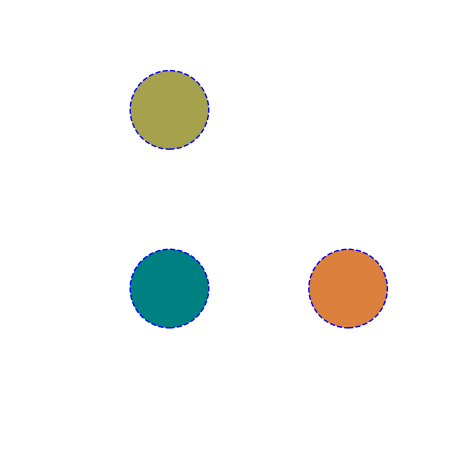

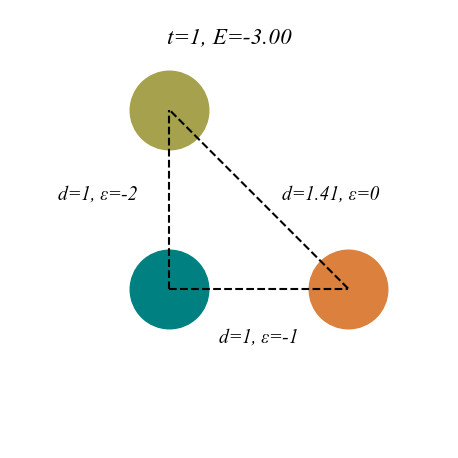

In [43]:
# initialize a system and plot it
a = np.array([0, 0])
b = np.array([1, 0])
c = np.array([0, 1])

# Save an initial one with no annotations as a reference
fig, ax = plot_configuration([a, b, c], kwdict={'edgecolors':'b','linestyle':'--'})
bounds = np.array([ax.get_xbound(), ax.get_ybound()])
plt.tight_layout()
plt.savefig('t0_no_annot.png', dpi=300, transparent=True)

eab = E_ab(np.linalg.norm(a-b))
eac = E_ac(np.linalg.norm(a-c))
ebc = E_bc(np.linalg.norm(b-c))
E = eab+eac+ebc

fig, ax = plot_configuration([a, b, c], bounds)
draw_lines(ax, a, b)
draw_lines(ax, a, c)
draw_lines(ax, b, c)

ax.annotate(f"d={np.linalg.norm(a-b):.0f}, ε={eab:.0f}", np.mean([a, b], axis=0)-[0, 0.3], ha='center')
ax.annotate(f"d={np.linalg.norm(a-c):.0f}, ε={eac:.0f}", np.mean([a, c], axis=0)-[0.4, 0], ha='center')
ax.annotate(f"d={np.linalg.norm(b-c):.2f}, ε={ebc:.0f}", np.mean([b, c], axis=0)+[0.4, 0], ha='center')

ax.set_title(f't=1, E={E:.2f}')



plt.tight_layout()
plt.savefig('t0.png', dpi=300, transparent=True)

print(f"Etot = {eab+eac+ebc:.2f}")

In [173]:
# Verlet integration
def velocity_verlet(xt, vt, at, interaction_masks):
    at1 = np.zeros_like(xt, dtype=np.float64) #acceleration at t+1
    xt1 = xt + vt*DT + 0.5*at*DT**2 #positions at t+1
    diff = xt1[np.newaxis,:] - xt1[:,np.newaxis] # vectors from all particles to all other particles
    
    # Loop over interacting sets of particles, applying the interaction.  Acceleration for an interaction is the sum over all pairs
    for im in interaction_masks:
        a = np.sum(im.function(diff[np.ix_(im.particles, im.particles)], **im.kwargs), axis=1)
        #print(a)
        at1[im.particles,:] += a

    # update, x, v, a
    return(xt1, vt + 0.5*(at+at1)*DT, at1)

In [68]:
# Actually run a simulation

a = np.array([0, 0])
b = np.array([1, 0])
c = np.array([0, 1])
#fig, ax = plot_configuration([a, b, c], bounds)

# turn it into a single numpy array for computation
x0 = np.array([a, b, c])
v0 = np.zeros_like(x0)
a0 = np.zeros_like(x0)

# create force calculation masks
interaction_masks = [Interaction([0,1], F_ab), Interaction([0,2], F_ac), Interaction([1,2], F_bc)]

x = x0
v = v0
a = a0
for i in range(100):
    x, v, a = velocity_verlet(x, v, a, interaction_masks)
    fig, ax = plot_configuration([x[0], x[1], x[2]], bounds)
    eab = E_ab(np.linalg.norm(x[0]-x[1]))
    eac = E_ac(np.linalg.norm(x[0]-x[2]))
    ebc = E_bc(np.linalg.norm(x[1]-x[2]))
    V = eab+eac+ebc
    draw_lines(ax, x[0], x[1])
    draw_lines(ax, x[0], x[2])
    draw_lines(ax, x[1], x[2])
    ax.annotate(f"d={np.linalg.norm(x[0]-x[1]):.2f}, ε={eab:.2f}", np.mean([x[0], x[1]], axis=0)-[0, 0.3], ha='center')
    ax.annotate(f"d={np.linalg.norm(x[0]-x[2]):.2f}, ε={eac:.2f}", np.mean([x[0], x[2]], axis=0)-[0.5, 0.1], ha='center')
    ax.annotate(f"d={np.linalg.norm(x[1]-x[2]):.2f}, ε={ebc:.2f}", np.mean([x[1], x[2]], axis=0)+[0.5, 0.1], ha='center')

    ax.set_title(f't={DT*i:.2f}, V={V:.2f}')
    plt.savefig(f'md_video/{i}.png', dpi=200)
    plt.close(fig)

In [88]:
# Run a simulation with an additional LJ term

def F_abl(r, **kwargs): return(F_ab(r) + F_lj(r, **kwargs)) 
def F_acl(r, **kwargs): return(F_ac(r) + F_lj(r, **kwargs))
def F_bcl(r, **kwargs): return(F_bc(r) + F_lj(r, **kwargs)) 

def E_abl(r, **kwargs): return(E_ab(r) + E_LJ(r, **kwargs)) 
def E_acl(r, **kwargs): return(E_ac(r) + E_LJ(r, **kwargs)) 
def E_bcl(r, **kwargs): return(E_bc(r) + E_LJ(r, **kwargs)) 


kwargs = {'mass': 1, 's': 0.5, 'e': 1}
# create force calculation masks
interaction_masks = [Interaction([0,1], F_abl, kwargs), Interaction([0,2], F_acl, kwargs), Interaction([1,2], F_bcl, kwargs)]

x = x0
v = v0
a = a0
for i in range(200):
    x, v, a = velocity_verlet(x, v, a, interaction_masks)
    fig, ax = plot_configuration([x[0], x[1], x[2]], bounds)
    eabl = E_abl(np.linalg.norm(x[0]-x[1]), **kwargs)
    eacl = E_acl(np.linalg.norm(x[0]-x[2]), **kwargs)
    ebcl = E_bcl(np.linalg.norm(x[1]-x[2]), **kwargs)
    V = eabl+eacl+ebcl
    draw_lines(ax, x[0], x[1])
    draw_lines(ax, x[0], x[2])
    draw_lines(ax, x[1], x[2])
    ax.annotate(f"d={np.linalg.norm(x[0]-x[1]):.2f}, ε={eabl:.2f}", np.mean([x[0], x[1]], axis=0)-[0, 0.3], ha='center')
    ax.annotate(f"d={np.linalg.norm(x[0]-x[2]):.2f}, ε={eacl:.2f}", np.mean([x[0], x[2]], axis=0)-[0.5, 0.1], ha='center')
    ax.annotate(f"d={np.linalg.norm(x[1]-x[2]):.2f}, ε={ebcl:.2f}", np.mean([x[1], x[2]], axis=0)+[0.5, 0.1], ha='center')

    ax.set_title(f't={DT*i:.2f}, V={V:.2f}')
    plt.savefig(f'md_video2/{i}.png', dpi=200)
    plt.close(fig)

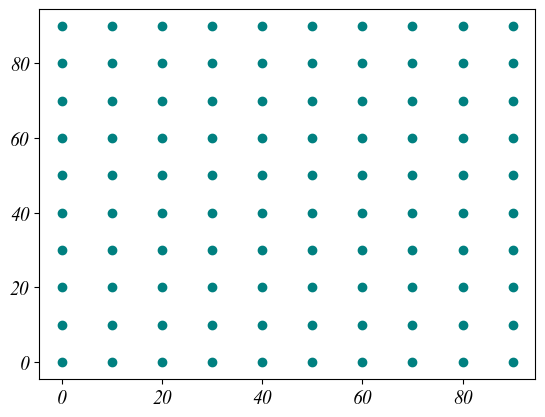

In [202]:
n_particles = 100
start_box = 100
mass = 83 #krypton
temperature = 1 #kelvin
#x0 = np.random.random(2*n_particles)*start_box
#x0 = x0.reshape((n_particles,2))
x = np.linspace(0, 90, 10)
x0 = np.array(np.array(np.meshgrid(x, x))).T.reshape(n_particles, 2)
v0 = np.empty_like(x0)
s0 = np.empty(n_particles)
for i in range(len(x0)):
    s0[i] = sample(temperature, mass) #this is technically speeds for 3D krypton, not 2D

vx = np.array([np.random.uniform(0, s) for s in s0**2])
vy = s0**2-vx
v0[:,0] = np.random.choice([-1, 1], len(vx))*np.sqrt(vx.T)
v0[:,1] = np.random.choice([-1, 1], len(vx))*np.sqrt(vy.T)
a0 = np.zeros_like(x0)

fig, ax = plt.subplots()
ax.scatter(x0[:,0], x0[:,1])

step: 0
step: 10
step: 20
step: 30
step: 40
step: 50
step: 60
step: 70
step: 80
step: 90


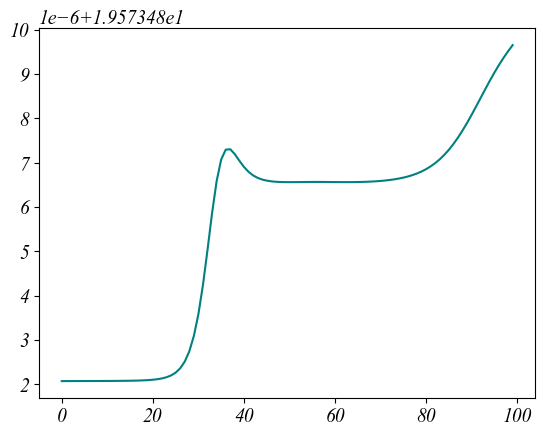

In [204]:
x = x0
v = v0
a = a0

kwargs = {'mass' : mass*amu_to_ng, 's' : 0.5, 'e' : 1}
interaction_masks = [Interaction(np.arange(n_particles), F_lj, kwargs)]
#vel0 = []
vel1 = []
#vel2 = []

n_steps = 100

for i in range(n_steps):
    if i%10 == 0: print("step:", i)
    x, v, a = velocity_verlet(x, v, a, interaction_masks)
    #print(v[1], a[1])
    #vel0.append(np.linalg.norm(v[0]))
    vel1.append(np.linalg.norm(v[1]))
    #vel2.append(np.linalg.norm(v[2]))
    x = inbox(x, start_box*2)
    ke = np.sum(np.linalg.norm(v)**2)/n_particles
    dists = np.linalg.norm(x[np.newaxis,:] - x[:,np.newaxis], axis=2)[np.tril_indices(len(x),-1)]
    pe = E_LJ(dists, **kwargs)
    pe_square = np.zeros((len(x), len(x)))
    lti = np.tril_indices(len(x),-1)
    pe_square[lti] = pe
    pe_square += pe_square.T
    pe_per_particle = np.sum(pe_square, axis=1)
    #pe = np.sum(E_LJ(1, np.linalg.norm(x[np.newaxis,:] - x[:,np.newaxis], axis=2)[np.tril_indices(len(x),-1)]), axis=1)*2
    pet = sum(pe_per_particle)/n_particles
    
    fig, ax = fig, ax = plt.subplots()
    p = ax.scatter(x[:,0], x[:,1], c=np.arange(n_particles), cmap='rainbow')

    ax.set_xbound(0, 100)
    ax.set_ybound(0, 100)

    ax.set_title(f't={DT*i:.2f}, KE={ke:.2f}, PE={pet:.2f}', y=1.05, pad=0)

    plt.colorbar(p, label='Energy')
    plt.savefig(f'md_video3/{i}.png', dpi=200)
    plt.close(fig)

fig, ax = plt.subplots()
#ax.plot(np.arange(n_steps), vel0)
ax.plot(np.arange(n_steps), vel1)
#ax.plot(np.arange(n_steps), vel2)
plt.show()


In [135]:
#einsum testing ground

a = np.array([[[0, 2], [2, 0], [-2, 0]],
              [[0, -2], [-2, 0], [1, 1]],
              [[1, -1], [-1, 1], [2, 1]]
               ])
b = np.sqrt(np.einsum('...i,...i', a, a))
print(b) # gets the magnitudes...
a/b[...,np.newaxis]

[[2.         2.         2.        ]
 [2.         2.         1.41421356]
 [1.41421356 1.41421356 2.23606798]]


array([[[ 0.        ,  1.        ],
        [ 1.        ,  0.        ],
        [-1.        ,  0.        ]],

       [[ 0.        , -1.        ],
        [-1.        ,  0.        ],
        [ 0.70710678,  0.70710678]],

       [[ 0.70710678, -0.70710678],
        [-0.70710678,  0.70710678],
        [ 0.89442719,  0.4472136 ]]])